In [ ]:
# !conda install -c conda-forge imbalanced-learn -y
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Reshape, Concatenate, Input
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Conv3D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
import psutil

import h5py
import gc

from sklearn.utils.class_weight import compute_class_weight

2.15.0
2.15.0


In [ ]:
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


def load_combine_shuffle_data_optimized_hdf5():
    with h5py.File('/content/drive/MyDrive/data.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for charge_type in ['positive-charge', 'negative-charge']:
            for data_type in ['sig', 'bkg']:
                # Construct dataset names
                input_dataset_name = f'{charge_type}_{data_type}_input'
                target_dataset_name = f'{charge_type}_{data_type}_target'

                # Check if the dataset exists and load data sequentially
                if input_dataset_name in h5f and target_dataset_name in h5f:
                    input_data = h5f[input_dataset_name][:].astype(np.float16)
                    target_data = h5f[target_dataset_name][:].astype(np.float16)

                    if combined_input is None:
                        combined_input = input_data
                        combined_target = target_data
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                    else:
                        print_memory_usage()
                        combined_input = np.vstack((combined_input, input_data))
                        combined_target = np.vstack((combined_target, target_data))
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                else:
                    print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

# Example usage
X, y = load_combine_shuffle_data_optimized_hdf5()


Total memory: 83.48 GB
Available memory: 78.56 GB
Used memory: 4.09 GB
Memory usage percentage: 5.9%
Total memory: 83.48 GB
Available memory: 77.42 GB
Used memory: 5.20 GB
Memory usage percentage: 7.3%
Total memory: 83.48 GB
Available memory: 76.36 GB
Used memory: 6.26 GB
Memory usage percentage: 8.5%


In [ ]:
X = X.reshape(-1, 8*13*21)
scaler = StandardScaler()
standard_batch_size = 10000  # Adjust based on your system's capability
n = X.shape[0]
# Fit the scaler incrementally
for start in range(0, X.shape[0], standard_batch_size):
    end = start + standard_batch_size
    scaler.partial_fit(X[start:end, :])

# Transform the data in batches
scaled_X = np.empty_like(X, dtype=np.float16)
for start in range(0, X.shape[0], standard_batch_size):
    end = start + standard_batch_size
    scaled_X[start:end, :] = scaler.transform(X[start:end, :])

# Clean up
X = scaled_X
del scaled_X
gc.collect()

# X = X.reshape(-1, 8*13*21)
# print_memory_usage()
# X = StandardScaler().fit_transform(X)
# del X_reshaped
# gc.collect()
X = X.reshape(n,8,13,21)
print_memory_usage()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y
gc.collect()
print_memory_usage()
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
del X_temp
del y_temp
gc.collect()
print_memory_usage()

Total memory: 83.48 GB
Available memory: 71.82 GB
Used memory: 10.80 GB
Memory usage percentage: 14.0%
Total memory: 83.48 GB
Available memory: 76.34 GB
Used memory: 6.28 GB
Memory usage percentage: 8.6%
Total memory: 83.48 GB
Available memory: 76.34 GB
Used memory: 6.28 GB
Memory usage percentage: 8.6%


In [ ]:
def to_sum(X, y):
    if X.shape[1:] == (8, 13, 21) and y.shape[1:] == (13, ):
        #y_expanded = np.repeat(y[:,7], 8, axis=0).reshape(-1, 8, 1)
        X_sum = np.sum(X, axis=3)
        X_sum.reshape(X_sum.shape[0],8,13,1)
        n = y.shape[0]
        one_hot = np.zeros((n, 3))

        # Class 1: np.abs(y[:, 8]) > 2
        one_hot[np.abs(y[:, 8]) >= 2, 0] = 1

        # Class 2: np.abs(y[:, 8]) <= 2 and y[:, 13] == 1
        one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] > 0), 1] = 1

        # Class 3: np.abs(y[:, 8]) <= 2 and y[:, 13] == -1
        one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] < 0), 2] = 1
        return X_sum, one_hot, y[:,7].reshape(-1, 1)
    else:
        raise ValueError("Wrong array shape!")


X_sum_train, y_sum_train, y0_train = to_sum(X_train, y_train)
X_sum_val, y_sum_val, y0_val = to_sum(X_val, y_val)
X_sum_test, y_sum_test, y0_test = to_sum(X_test, y_test)
del X_train
del y_train
del X_val
del y_val
del X_test
del y_test
gc.collect()
print_memory_usage()

Total memory: 83.48 GB
Available memory: 80.57 GB
Used memory: 2.04 GB
Memory usage percentage: 3.5%


In [ ]:
from keras.layers import Input, LSTM, Flatten, Concatenate, Dense, Conv1D, TimeDistributed
from keras.models import Model
def LSTMmodel():
    # Cluster y-profile input
    y_profile_input = Input(shape=(8, 13, 1))  # Adjust the shape based on your input

    # LSTM layers
    # lstm_layer = LSTM(16, activation='relu', return_sequences=False, recurrent_dropout=0.5, input_shape=(8, 13))
    # lstm_output = lstm_layer(y_profile_input)
    conv1 = TimeDistributed(Conv1D(16, 3, activation='relu', strides=1))(y_profile_input)
    conv2 = TimeDistributed(Conv1D(64, 3, activation='relu', strides=1))(conv1)

    reshaped = Reshape((8, -1))(conv2)  # Adjust the shape based on the output of Conv1D

    # LSTM layer
    lstm_output = LSTM(32, activation='relu', return_sequences=False, recurrent_dropout=0.5)(reshaped)

    # Flatten and concatenate with y0 input
    y0_input = Input(shape=(1,))
    concat = Concatenate()([lstm_output, y0_input])

    # Dense layer
    dense = Dense(16, activation='relu')(concat)
    dropout = Dropout(0.5)(dense) # best so far 0.4

    # Output layer (adjust based on your classification problem)
    output = Dense(3, activation='softmax')(dropout)  # Change number of neurons based on the number of classes

    model = Model(inputs=[y_profile_input, y0_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and summarize the model
model = LSTMmodel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 13, 1)]           0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 8, 11, 16)            64        ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 8, 9, 64)             3136      ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

In [ ]:
checkpoint_path = "cp.ckpt"
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                   mode='max',
                                   patience=30,
                                   restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)
csv_logger = CSVLogger('log.csv', append=False, separator=';')

In [ ]:

class_labels = np.argmax(y_sum_train, axis=1)

# Now use class_labels to compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:

model = LSTMmodel()

# Define training parameters
epochs = 200  # Number of epochs to train
batch_size = 1024  # Number of samples per gradient update

# Train the model
history = model.fit(
    [X_sum_train, y0_train], y_sum_train,  # Training data and labels
    validation_data=([X_sum_val, y0_val], y_sum_val),  # Validation data
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[earlyStop_callback]
)

Epoch 1/200
860/860 [==============================] - 23s 22ms/step - loss: 1.0448 - accuracy: 0.4938 - val_loss: 1.0132 - val_accuracy: 0.4999
Epoch 2/200
860/860 [==============================] - 19s 22ms/step - loss: 0.9982 - accuracy: 0.5117 - val_loss: 0.9715 - val_accuracy: 0.5186
Epoch 3/200
860/860 [==============================] - 19s 22ms/step - loss: 0.9803 - accuracy: 0.5238 - val_loss: 0.9550 - val_accuracy: 0.5352
Epoch 4/200
860/860 [==============================] - 19s 22ms/step - loss: 0.9669 - accuracy: 0.5321 - val_loss: 0.9474 - val_accuracy: 0.5516
Epoch 5/200
860/860 [==============================] - 19s 22ms/step - loss: 0.9557 - accuracy: 0.5402 - val_loss: 0.9330 - val_accuracy: 0.5556
Epoch 6/200
860/860 [==============================] - 19s 22ms/step - loss: 0.9473 - accuracy: 0.5456 - val_loss: 0.9130 - val_accuracy: 0.5718
Epoch 7/200
860/860 [==============================] - 19s 22ms/step - loss: 0.9395 - accuracy: 0.5505 - val_loss: 0.9076 - val_ac

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

3437/3437 [==============================] - 14s 4ms/step


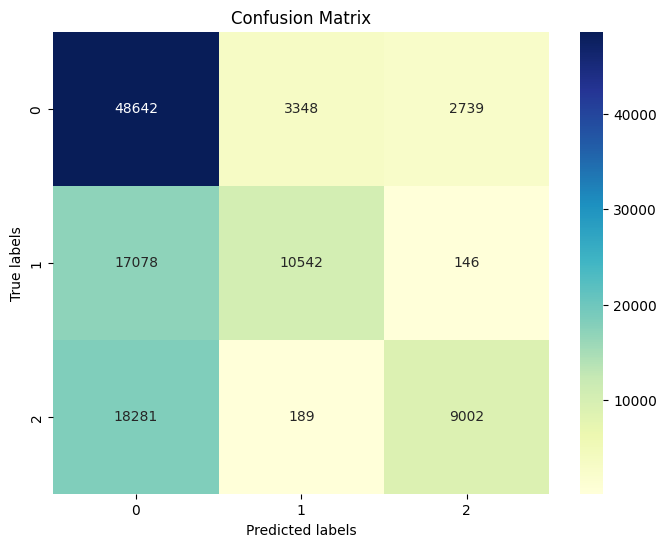

In [ ]:
from sklearn.metrics import confusion_matrix
predictions_prob = model.predict([X_sum_test, y0_test])
predictions_labels = np.argmax(predictions_prob, axis=1)
y_test_labels = np.argmax(y_sum_test, axis=1)
cm = confusion_matrix(y_test_labels, predictions_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Signal Efficiency
signal_efficiency = cm[0, 0] / np.sum(cm[0, :])

# Background Rejection Rate
background_rejection = (cm[1, 1] + cm[1, 2]+cm[2, 1] + cm[2, 2]) / (np.sum(cm[1, :]) + np.sum(cm[2, :]))

print("Signal Efficiency:", signal_efficiency)
print("Background Rejection Rate:", background_rejection)

Signal Efficiency: 0.8887792577975113
Background Rejection Rate: 0.3598790687570151


In [ ]:
from sklearn.metrics import roc_auc_score
class_1_true = y_sum_test[:, 0]
class_1_scores = predictions_prob[:, 0]

# Calculate the AUC for class 1
class_1_auc = roc_auc_score(class_1_true, class_1_scores)

print("Class 1 AUC:", class_1_auc)

Class 1 AUC: 0.6601289284299923


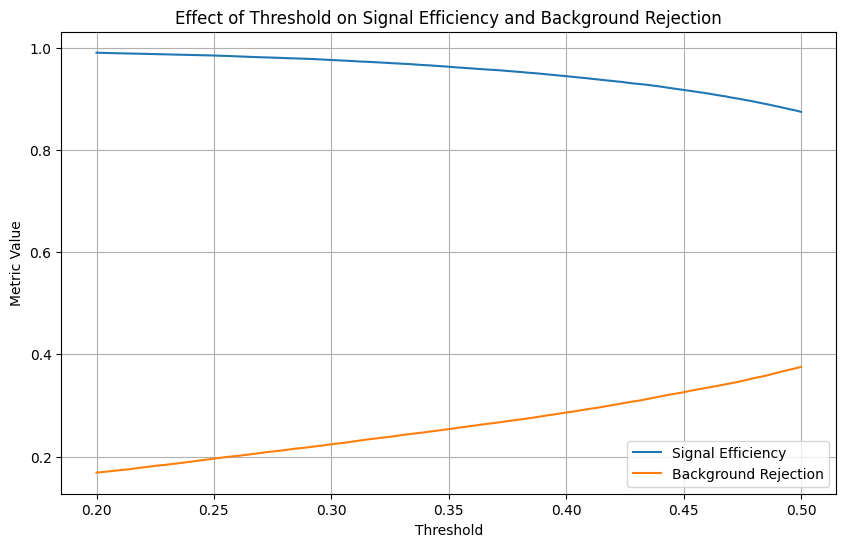

In [ ]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.2, 0.5, 500)
signal_efficiencies = []
background_rejections = []

for threshold in thresholds:
    # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
    predicted_class = (predictions_prob[:, 0] > threshold).astype(int)
    # Compute confusion matrix
    cm = confusion_matrix(y_sum_test[:, 0], predicted_class)

    # Calculate signal efficiency and background rejection
    signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
    background_rejection = cm[0, 0] / np.sum(cm[0, :])

    # Store metrics
    signal_efficiencies.append(signal_efficiency)
    background_rejections.append(background_rejection)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency')
plt.plot(thresholds, background_rejections, label='Background Rejection')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Effect of Threshold on Signal Efficiency and Background Rejection')
plt.legend()
plt.grid(True)
plt.show()

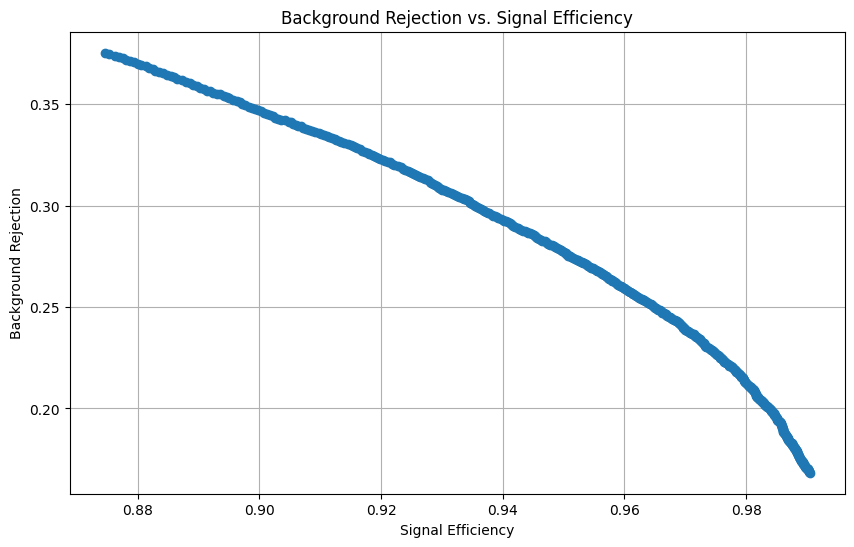

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(signal_efficiencies, background_rejections, marker='o')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Background Rejection vs. Signal Efficiency')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_sum_test, predictions_prob)
print(f"AUC: {auc}")

AUC: 0.7560903522323347


In [ ]:
def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)

    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)

    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)

    return closest_index


index_848 = find_closest(signal_efficiencies, 0.848)
index_933 = find_closest(signal_efficiencies, 0.933)
index_976 = find_closest(signal_efficiencies, 0.976)
print(f"Signal Efficiency:{signal_efficiencies[index_848]*100:.1f}%",f"Background Rejections:{background_rejections[index_848]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_933]*100:.1f}%",f"Background Rejections:{background_rejections[index_933]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_976]*100:.1f}%",f"Background Rejections:{background_rejections[index_976]*100:.1f}%")

Signal Efficiency:87.5% Background Rejections:37.5%
Signal Efficiency:93.3% Background Rejections:30.4%
Signal Efficiency:97.6% Background Rejections:22.5%


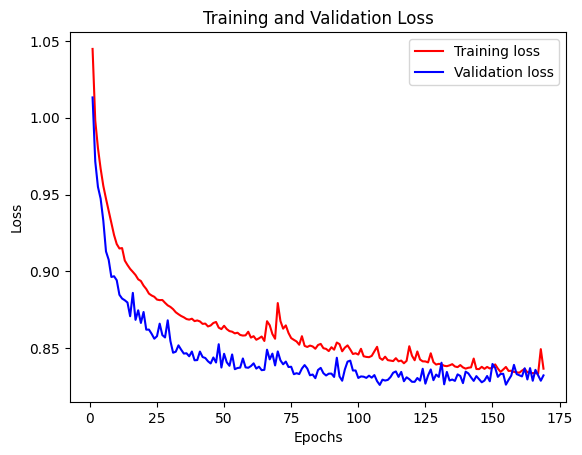

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

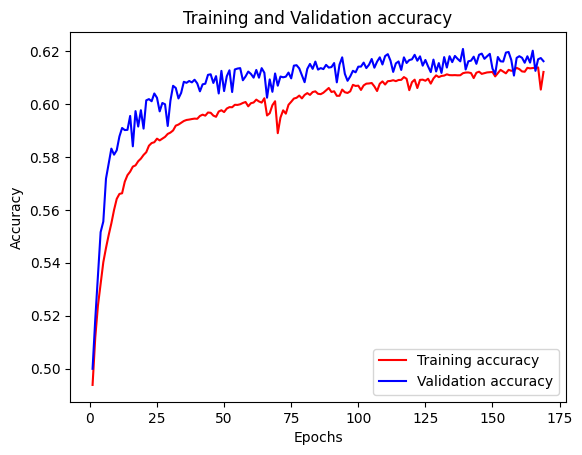

In [ ]:
epochs = range(1, len(train_accuracy) + 1)
plt.figure()
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(np.sum(y_sum_train[:,0]))
print(y_sum_train.shape)
print(np.sum(y_sum_test[:,0]))
print(y_sum_test.shape)

440198.0
(879734, 3)
54729.0
(109967, 3)


In [ ]:
print(train_accuracy, val_accuracy)

[0.493794709444046, 0.5117137432098389, 0.523823082447052, 0.5321494936943054, 0.5402019023895264, 0.5456047058105469, 0.5504811406135559, 0.5549154877662659, 0.559968113899231, 0.5641660094261169, 0.5660369992256165, 0.566287100315094, 0.5706645250320435, 0.5731357336044312, 0.5744622945785522, 0.5763662457466125, 0.5768402814865112, 0.5784009695053101, 0.5793887972831726, 0.580786943435669, 0.5818145275115967, 0.584275484085083, 0.5852769017219543, 0.5855940580368042, 0.5869399309158325, 0.5862795114517212, 0.5869330763816833, 0.5876173973083496, 0.5887348055839539, 0.5892383456230164, 0.5900499224662781, 0.5918675661087036, 0.5922733545303345, 0.5929462909698486, 0.5936214923858643, 0.5940102338790894, 0.5941625833511353, 0.5943671464920044, 0.5945240259170532, 0.5944569706916809, 0.5955265760421753, 0.5960187911987305, 0.5956459641456604, 0.5968349575996399, 0.596733808517456, 0.5956652760505676, 0.5952117443084717, 0.5972009897232056, 0.5976920127868652, 0.5969997644424438, 0.5983

In [ ]:
model.save('CNN_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
